In [1]:
from glob import glob
import json
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
import orjson as json
import numpy as np
from scipy.spatial import KDTree
import seaborn as sns

In [2]:
from datasets import load_dataset

dataset = load_dataset("mesolitica/bge-large-en-embedding", data_files="iium-confession.jsonl")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'v'],
        num_rows: 333694
    })
})

In [5]:
len(dataset["train"])

333694

In [23]:
dataset["train"][0]

{'text': {'left': 'So aku ambik pendekatan untuk cuba ubah suami aku. Bebel tu tidak la secara kasar, perli atau baling senduk. Aku banyak guna ayat "Awak, tolong buat ni", "terima kasih tolong" , "alhamdulillah awak tolong, boleh la tidur awal" macam tu. Kene buat hari-hari. Lama-lama dia tahu sendiri yang benda2 ni kena buat sebelum masuk tidur. Sebab kalau perli ke apa, buat gaduh tambah dosa je. Lelaki ego ni bukan boleh. Semua nak menang. Aku depressed kang salah aku jugak. Mana pernah salah dia.',
  'en': 'So I took an approach to try and change my husband. I didn\'t nag him harshly, make fun of him, or throw things at him. I used a lot of phrases like "Can you please do this", "Thank you for helping", "Alhamdulillah you helped, now you can sleep early" and so on. I had to do it every day. Eventually, he knew himself that these things had to be done before going to bed. Because if I made fun of him or something, it would just cause more trouble. Men and their egos, they always wa

In [3]:
data = []

for x in range(len(dataset["train"])):
    data.append(dataset["train"][x])

In [8]:
len(data)

333694

In [4]:
vectors, texts = [], []

for d in data:
    vectors.append(d["v"])
    texts.append(d["text"])

In [5]:
concat = np.array(vectors)
concat.shape

(333694, 1024)

In [6]:
%%time

kd_tree = KDTree(concat, leafsize = 40)

CPU times: user 5.82 s, sys: 75.3 ms, total: 5.9 s
Wall time: 5.9 s


In [36]:
%%time

dist, ind = kd_tree.query(concat[:1000], k=len(concat), workers = 1000)

CPU times: user 29min 49s, sys: 26min 48s, total: 56min 37s
Wall time: 7min 9s


/tmp/ipykernel_490568/3913103053.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist)


<Axes: ylabel='Density'>

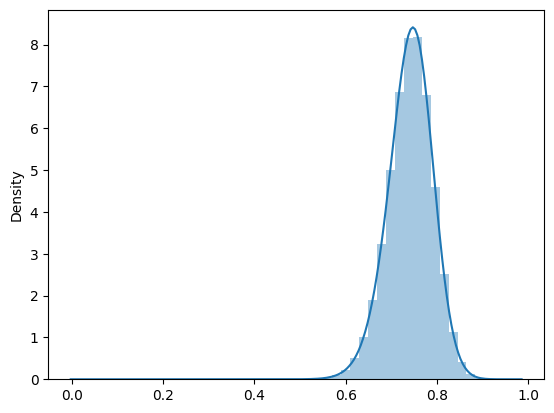

In [37]:
sns.distplot(dist)

In [72]:
dist[dist > 0.9].shape

(71070,)

In [18]:
dist[dist <= 0.3].shape

NameError: name 'dist' is not defined

In [7]:
keys = list(texts[0].keys())
keys

['left', 'en', 'ms']

In [8]:
# !wget https://gist.githubusercontent.com/huseinzol05/98974ae8c6c7a65d4bc0af9f5003786a/raw/5aa5257608b61e8fcc828e99fbd070d5ca7358e3/mp.py
import mp

def dedup(strings):
    unique_neg = []
    elements = set()

    for n in strings:
        x_lower = n.lower()
        if x_lower not in elements:
            elements.add(x_lower)
            unique_neg.append(n)
    return unique_neg

dedup(['a', 'a'])

['a']

In [9]:
import time

lower_bound = 0.45
upper_bound = 0.7

def loop(data):
    data, index = data
    with open(f'iium/iium-train-dataset-{index}.jsonl', 'w') as fopen:
        for x in tqdm(data):
            dist, ind = kd_tree.query(concat[x], k=len(concat), workers = 1)

            for key in keys:

                query = texts[x][key]

                pos_indices = [k for k in ind[dist <= lower_bound]]
                neg_indices = [k for k in ind[dist > upper_bound]]

                if len(neg_indices) > 5:
                    neg_indices = random.sample(neg_indices,5)
                if len(pos_indices) > 5:
                    rand_pos = random.sample(pos_indices,4)
                    rand_pos.append(x)
                    pos_indices = rand_pos


                pos = [value for i in pos_indices for value in texts[i].values() if value != query ]

                neg = [value for i in neg_indices for value in texts[i].values()]
                
                d = {"query":query,"pos":dedup(pos),"neg":dedup(neg)}
#                 print(d)
#                 fopen.write(f"{json.dumps(d)}\n")
                fopen.write(f"{json.dumps(d).decode()}\n")
                fopen.flush()

In [ ]:
import mp

mp.multiprocessing(range(len(data)), loop, cores = 30, returned = False)

  1%|          | 64/11123 [01:40<5:27:22,  1.78s/it]

In [11]:
from huggingface_hub import hf_hub_url

In [12]:
config_file_url = hf_hub_url("mesolitica/bge-large-en-embedding", filename="iium-confession.jsonl")
config_file_url

'https://huggingface.co/mesolitica/bge-large-en-embedding/resolve/main/iium-confession.jsonl'